Import:

In [87]:
import numpy as np
from scipy.integrate import odeint
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import seaborn as sns
from random import gauss

Parameters:

In [116]:
# Total population, N.
N = 8.5*10**6
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 246, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
D0 = 0 #no death at t0

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 2.4/11, 1./11 #multiplied by 36 
print("R_0 =", beta/gamma)

#mortality rate
m = 3./100

#Nb days of simulation
D = 300
time = np.linspace(0, D, D)

#Hospital_capacity
beds = 844
resp = 777

#Quarantine: isolation of symptomatic people
StartQ = 100 #how many days after 
Quarantine = {"no":0, "yes":0.75} #yes: percentage of sick people showing symptoms
Q = Quarantine["no"]

#Back to normal
DayBTN = float('inf')

R_0 = 2.4


Computation:

In [117]:
#initialize data to plot
S_array = np.ones(D)*S0
I_array = np.ones(D)*I0
R_array = np.ones(D)*R0
De_array = np.zeros(D)
Severe   = np.zeros(D)
Critical = np.zeros(D)


# The SIRD model differential equations.
def deriv(y, t, N, beta, gamma, day): 
    S, I, R, De = y
   
    #risk people
    Severe[day]    = I* 0.15 #require hosp
    Critical[day]  = I* 0.05 #require resp
    
    #quarantined people
    q=0
    if day >= StartQ:
        q = I*Q
    if day >= DayBTN:
        q = 0
    
    #check hospital capacity
    if Critical[day] > resp:
        m_r = 2.5*m
    elif Severe[day]+Critical[i] > beds: 
        m_r = 2*m
    else: m_r = m
    
    
    #diff eq
    dSdt = -beta * S * (I-q) / N
    dIdt = beta * S * (I-q) / N - gamma * I
    dRdt = (1-m_r)*gamma * I
    dDedt = gamma*m_r*I
    
    return dSdt, dIdt, dRdt, dDedt

# Initial conditions vector
t=[0,1]
y0 = S0, I0, R0, D0

# Integrate the SIRD equations over the time grid, t.
for i in range(1,D):
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, i))
    
    S, I, R, De = ret.T
    
    S_array[i]   = S[1]
    I_array[i]   = I[1]
    R_array[i]   = R[1]
    De_array[i]  = De[1]
    y0 = S[1], I[1], R[1], De[1]

#get total death and infected
Tot_death = De_array[len(De_array)-1]
Percentage_death = Tot_death/N*100
Tot_infected = R_array[len(R_array)-1]
Percentage_infected = Tot_infected/N*100


Plots

Death:  559350.1938078286
% Death:  6.580590515386218
Infected:  6908749.632356609
% infected 81.27940743948952


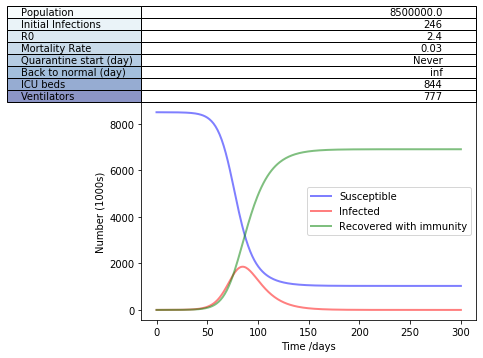

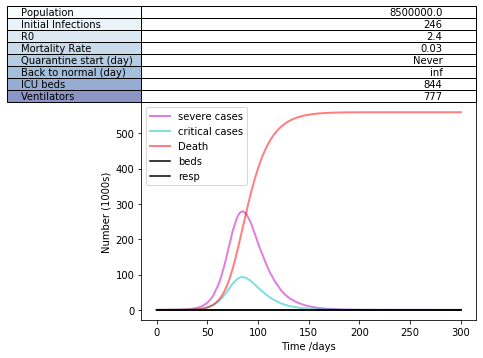

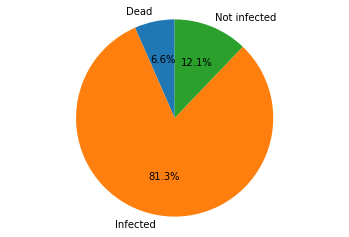

In [118]:
#Info for table
rows = ("Population", "Initial Infections", "R0", "Mortality Rate", "Quarantine start (day)", "Back to normal (day)", "ICU beds", "Ventilators")
quarantine_start = "Never"
if Q != 0:
    quarantine_start = StartQ
data = [[N], [I0], [beta/gamma], [m], [quarantine_start], [DayBTN], [beds], [resp]]
colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))

# Prints
print("Death: ", Tot_death)
print("% Death: ", Percentage_death)
print("Infected: ", Tot_infected)
print("% infected", Percentage_infected)

#plot SIR 
fig1 = plt.figure(facecolor='w')
plt.plot(time, S_array/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
plt.plot(time, I_array/1000, 'r', alpha=0.5, lw=2, label='Infected')
plt.plot(time, R_array/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
plt.xlabel('Time /days')
plt.ylabel('Number (1000s)')

plt.table(cellText=data, rowLabels=rows, rowColours=colors, loc='top')
legend = plt.legend()
#plt.savefig('NoMesSIR.png', bbox_inches="tight", pad_inches=1)


#Plot deaths and critical
fig2 = plt.figure(facecolor='w')
plt.plot(time, Severe/1000,  'm', alpha=0.5, lw=2, label='severe cases')
plt.plot(time, Critical/1000, 'c', alpha=0.5, lw=2, label='critical cases')
plt.plot(time, De_array/1000, 'r', alpha=0.5, lw=2, label='Death')


plt.plot([0,D], [beds/1000, beds/1000], 'k', label='beds')
plt.plot([0,D], [resp/1000, resp/1000],'k', label='resp')
plt.table(cellText=data, rowLabels=rows, rowColours=colors, loc='top')

plt.xlabel('Time /days')
plt.ylabel('Number (1000s)')
legend = plt.legend()
#plt.savefig('NoMesD.png', bbox_inches="tight", pad_inches=1)


#Pie Chart
labels = 'Dead', 'Infected', 'Not infected'
sizes = [Percentage_death, Percentage_infected, 100-Percentage_death-Percentage_infected]
#explode = (0.1, 0.1, 0)  

fig3, ax3 = plt.subplots()
ax3.pie(sizes, explode=None, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('NoMesPie.png')


plt.show()

Animation (not working yet)

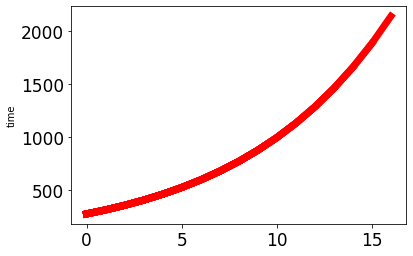

In [119]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=1800)

def animate(i):
    data_pd = pd.DataFrame(I_array[1:]).astype(float)
    data_pd.columns = {"time"}
    data =data_pd[:int(i+1)] #select data range
    p = sns.lineplot(x=data.index, y=data["time"], data=data, color="r")
    p.tick_params(labelsize=17)
    plt.setp(p.lines,linewidth=7)

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=17, repeat=True)
ani.save('TestAnim.mp4', writer=writer)